<a href="https://colab.research.google.com/github/qmeng222/CNN/blob/main/transfer-learning/autoencoder_pretraining_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tasks:
- import CIFAR-10 (RGB) dataset & create "full" / "small" subsets
- create a CNN autoencoder & train it
- transfer the autoencoding layers to a classification model (the CNN layers of the model are the same as the encoder part of the autoencoder, followed by some fully connected linear layers at the end instead of the decoder layers)
- train a "naive" model (with random weights) to classify
- run another model that transfers the encoder weights & fine tune

In [7]:
# for importing data
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader,Subset

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import copy

import matplotlib.pyplot as plt
import matplotlib_inline as inl
inl.backend_inline.set_matplotlib_formats("svg")

In [8]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [9]:
device

device(type='cpu')

# Import the CIFAR-10 dataset:

In [10]:
# transformations
transform = T.Compose([ T.ToTensor(),
                        T.Normalize([.5,.5,.5],[.5,.5,.5])
                       ])

# import the data and simultaneously apply the transform
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,  download=True, transform=transform)
testset  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# transform to dataloaders
batchsize        = 32
train_loaderFull = DataLoader(trainset,batch_size=batchsize,shuffle=True,drop_last=True)
test_loaderFull  = DataLoader(testset, batch_size=256)

Files already downloaded and verified
Files already downloaded and verified


In [11]:
# Create smaller DataLoaders with only 2k images (used later)

trainsetSmall = torch.utils.data.Subset(trainset,range(2000))
train_loaderSmall = DataLoader(trainsetSmall,batch_size=batchsize,shuffle=True)

testsetSmall = torch.utils.data.Subset(testset,range(2000))
test_loaderSmall = DataLoader(testsetSmall,batch_size=batchsize,shuffle=True)

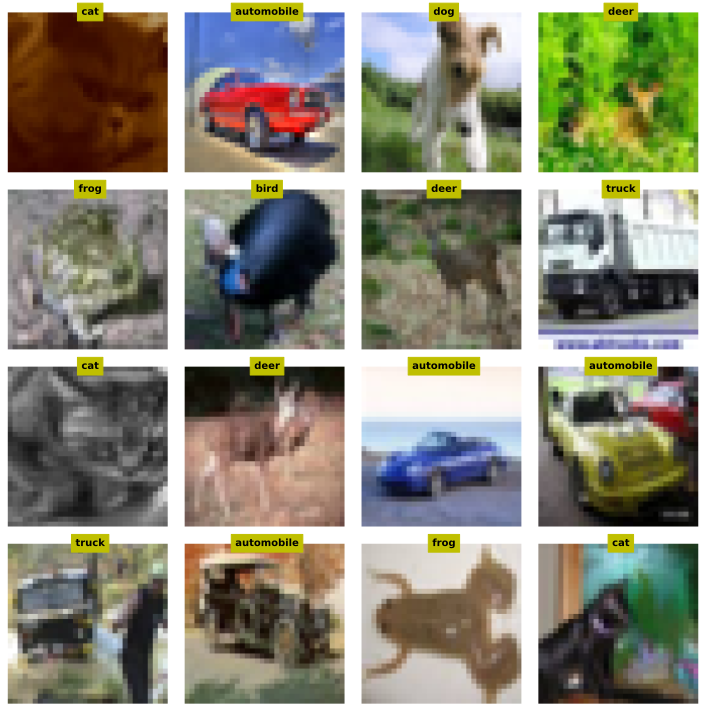

In [12]:
# inspect a few random images

X,y = next(iter(train_loaderSmall))

fig,axs = plt.subplots(4,4,figsize=(10,10))

for (i,ax) in enumerate(axs.flatten()):

  # extract that image (need to transpose it back to 32x32x3)
  pic = X.data[i].numpy().transpose((1,2,0))
  pic = pic/2 + .5 # undo normalization

  # and its label
  label = trainset.classes[y[i]]

  # and show!
  ax.imshow(pic)
  ax.text(16,0,label,ha='center',fontweight='bold',color='k',backgroundcolor='y')
  ax.axis('off')

plt.tight_layout()
plt.show()

# Build an autoencoder:

In [13]:
def makeTheAENet(printtoggle=False):

  class aenet(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()

      # print toggle
      self.print = printtoggle

      ### -------------- encoding layers -------------- ###
      # first convolution layer
      self.encconv1  = nn.Conv2d(3,16,4,padding=1,stride=2) # note: using stride instead of pool to downsample
      # output size: (32+2*1-4)/2 + 1 = 16

      # second convolution layer
      self.encconv2  = nn.Conv2d(16,32,4,padding=1,stride=2)
      # output size: (16+2*1-4)/2 + 1 = 8

      # third convolution layer
      self.encconv3  = nn.Conv2d(32,64,4,padding=1,stride=2)
      # output size: (8+2*1-4)/2 + 1 = 4


      ### -------------- decoding layers -------------- ###

      # first convolution layer
      self.decconv1  = nn.ConvTranspose2d(64,32,4,padding=1,stride=2)

      # second convolution layer
      self.decconv2  = nn.ConvTranspose2d(32,16,4,padding=1,stride=2)

      # third convolution layer (output)
      self.decconv3  = nn.ConvTranspose2d(16,3,4,padding=1,stride=2)


    def forward(self,x):

      if self.print: print(f'Input: {list(x.shape)}')

      # encoder blocks
      x = F.leaky_relu( self.encconv1(x) )
      if self.print: print(f'First encoder block: {list(x.shape)}')

      x = F.leaky_relu( self.encconv2(x) )
      if self.print: print(f'Second encoder block: {list(x.shape)}')

      x = F.leaky_relu( self.encconv3(x) )
      if self.print: print(f'Third encoder block: {list(x.shape)}')

      # decoder blocks
      x = F.leaky_relu( self.decconv1(x) )
      if self.print: print(f'First decoder block: {list(x.shape)}')

      x = F.leaky_relu( self.decconv2(x) )
      if self.print: print(f'Second decoder block: {list(x.shape)}')

      x = F.leaky_relu( self.decconv3(x) )
      if self.print: print(f'Decoder output: {list(x.shape)}')

      return x

  # create the model instance
  net = aenet(printtoggle)

  # loss function
  lossfun = nn.MSELoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001,weight_decay=1e-5)

  return net,lossfun,optimizer

In [14]:
# test the AE model with one batch
aenet,lossfun,optimizer = makeTheAENet(True)

X,y = next(iter(train_loaderSmall))
yHat = aenet(X)

# now compute the loss
loss = lossfun(yHat,X)
print(' ')
print('Loss:')
print(loss)

Input: [32, 3, 32, 32]
First encoder block: [32, 16, 16, 16]
Second encoder block: [32, 32, 8, 8]
Third encoder block: [32, 64, 4, 4]
First decoder block: [32, 32, 8, 8]
Second decoder block: [32, 16, 16, 16]
Decoder output: [32, 3, 32, 32]
 
Loss:
tensor(0.2387, grad_fn=<MseLossBackward0>)


# A function to train the autoencoder:

In [15]:
def function2trainTheAEModel(net,lossfun,optimizer):

  # number of epochs
  numepochs = 15

  # send the model to the GPU
  net.to(device)

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  testLoss  = torch.zeros(numepochs)


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    net.train() # switch to train mode
    batchLoss = []

    for X,y in train_loaderFull:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,X)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss and accuracy from this batch
      batchLoss.append(loss.item())
    # end of batch loop...

    # and get average losses and accuracies across the batches
    trainLoss[epochi] = np.mean(batchLoss)


    #### test performance (here done in batches!)
    net.eval() # switch to test mode
    batchLoss = []

    for X,y in test_loaderFull:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      with torch.no_grad():
        yHat = net(X)
        loss = lossfun(yHat,X)

      # loss and accuracy from this batch
      batchLoss.append(loss.item())
    # end of batch loop...

    # and get average losses and accuracies across the batches
    testLoss[epochi] = np.mean(batchLoss)

  # end epochs

  # function output
  return trainLoss,testLoss,net

# Run the AE model & show the results:

In [16]:
# ~3 minutes with 15 epochs on GPU

# create a new model (comment out to re-train)
netAE,lossfun,optimizer = makeTheAENet()

trainLossAE,testLossAE,netAE = function2trainTheAEModel(netAE,lossfun,optimizer)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-e3e246bc25ce>", line 6, in <cell line: 6>
    trainLossAE,testLossAE,netAE = function2trainTheAEModel(netAE,lossfun,optimizer)
  File "<ipython-input-15-3e970ad02dc9>", line 28, in function2trainTheAEModel
    yHat = net(X)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "<ipython-input-13-cc6f215d96b6>", line 54, in forward
    x = F.leaky_relu( self.decconv2(x) )
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py", line 956, in forward
    return F.conv_transpose2d(
KeyboardInterrupt

During handling of t

TypeError: ignored

In [ ]:
plt.plot(trainLossAE,'s-',label='AE Train')
plt.plot(testLossAE,'o-',label='AE Test')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Model loss (final value: %g)'%testLossAE[-1])
plt.legend()

plt.show()

In [ ]:
# show some random examples

# get some data
X,y = next(iter(test_loaderSmall))

# forward pass and loss
netAE.cpu()
netAE.eval() # switch to test mode
yHat = netAE(X)


fig,axs = plt.subplots(2,10,figsize=(14,4))

for i in range(10):
  pic = yHat[i,:,:,:].detach().numpy().transpose((1,2,0))
  pic = pic/2 + .5 # undo normalization
  axs[0,i].imshow(pic)
  axs[0,i].set_title(f'[ {np.min(pic):.2f}, {np.max(pic):.2f} ]',fontsize=10)
  axs[0,i].axis('off')

  pic = X[i,:,:,:].detach().numpy().transpose((1,2,0))
  pic = pic/2 + .5 # undo normalization
  axs[1,i].imshow(pic)
  axs[1,i].set_title(f'[ {np.min(pic):.2f}, {np.max(pic):.2f} ]',fontsize=10)
  axs[1,i].axis('off')

plt.show()

# Create the classification model:

In [ ]:
# create a class for the model
def makeTheClassNet(printtoggle=False):

  class cnnnet(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()

      # print toggle
      self.print = printtoggle

      # -------------- encoding layers --------------

      # first convolution layer
      self.encconv1  = nn.Conv2d(3,16,4,padding=1,stride=2) # note: using stride instead of pool to downsample
      # output size: (28+2*1-4)/2 + 1 = 14

      # second convolution layer
      self.encconv2  = nn.Conv2d(16,32,4,padding=1,stride=2)
      # output size: (14+2*1-4)/2 + 1 = 7

      # third convolution layer
      self.encconv3  = nn.Conv2d(32,64,4,padding=1,stride=2)
      # output size: (7+2*1-4)/2 + 1 = 4

      # ------------- linear layers -------------

      self.fc1  = nn.Linear(4*4*64,128)
      self.fc2  = nn.Linear(128,64)
      self.fc3  = nn.Linear(64,10) # output (10 categories)


    def forward(self,x):

      if self.print: print(f'Input: {list(x.shape)}')

      # first encoder layer
      x = F.leaky_relu(self.encconv1(x))
      if self.print: print(f'First encoder layer: {list(x.shape)}')

      # second encoder layer
      x = F.leaky_relu(self.encconv2(x))
      if self.print: print(f'Second encoder layer: {list(x.shape)}')

      # third encoder layer
      x = F.leaky_relu(self.encconv3(x))
      if self.print: print(f'Third encoder layer: {list(x.shape)}')

      # reshape to linear
      nUnits = x.shape.numel()/x.shape[0]
      x = x.view(-1,int(nUnits))
      if self.print: print(f'Post-convolution vectorized: {list(x.shape)}')

      # linear layers
      x = F.leaky_relu(self.fc1(x))
      if self.print: print(f'First linear layer: {list(x.shape)}')

      x = F.leaky_relu(self.fc2(x))
      if self.print: print(f'Second linear layer: {list(x.shape)}')

      x = F.leaky_relu(self.fc3(x))
      if self.print: print(f'Output linear layer: {list(x.shape)}')

      return x

  # create the model instance
  net = cnnnet(printtoggle)

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [ ]:
# test the model with one batch
tmpnet,lossfun,optimizer = makeTheClassNet(True)

X,y = next(iter(train_loaderSmall))
yHat = tmpnet(X)

# # now let's compute the loss
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

# A function to train the classifier:

In [ ]:
def function2trainTheClassModel(net,lossfun,optimizer,train_loader,test_loader):

  # number of epochs
  numepochs = 10

  # send the model to the GPU
  net.to(device)

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  testLoss  = torch.zeros(numepochs)
  trainAcc  = torch.zeros(numepochs)
  testAcc   = torch.zeros(numepochs)


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    net.train() # switch to train mode
    batchLoss = []
    batchAcc  = []

    for X,y in train_loader:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss and accuracy from this batch
      batchLoss.append(loss.item())
      batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
    # end of batch loop...

    # and get average losses and accuracies across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainAcc[epochi]  = 100*np.mean(batchAcc)

    # test performance (here done in batches!)
    net.eval() # switch to test mode
    batchLoss = []
    batchAcc  = []

    for X,y in test_loader:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      with torch.no_grad():
        yHat = net(X)
        loss = lossfun(yHat,y)

      # loss and accuracy from this batch
      batchLoss.append(loss.item())
      batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
    # end of batch loop...

    # and get average losses and accuracies across the batches
    testLoss[epochi] = np.mean(batchLoss)
    testAcc[epochi]  = 100*np.mean(batchAcc)

  # end epochs

  # function output
  return trainLoss,testLoss,trainAcc,testAcc,net

In [ ]:
# train the classifier from scratch (not pre-trained!)

# create a naive network
naivenet,lossfun,optimizer = makeTheClassNet()

# train it from scratch
trainLossNaive,testLossNaive,trainAccNaive,testAccNaive,naivenet = function2trainTheClassModel(
    naivenet,lossfun,optimizer,train_loaderSmall,test_loaderSmall)

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLossNaive,'s-',label='Train')
ax[0].plot(testLossNaive,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')

ax[1].plot(trainAccNaive,'s-',label='Train')
ax[1].plot(testAccNaive,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAccNaive[-1]:.2f}%')
ax[1].legend()

plt.show()

# Build a new classifier but replace the convolutional layers with encoding layers:

In [ ]:
# create a new network (weights replaced below)
pretrainNet,lossfun,optimizer = makeTheClassNet() # NOTE: a fresh model with random initialized weights

# replace the conv weights in TARGET model from encoder weights in SOURCE model
for target,source in zip(pretrainNet.named_parameters(),aenet.named_parameters()):
  print('PRETRAIN: ' + target[0] + '  AENET: ' + source[0])

  if 'enc' in target[0]:

    # copy over the parameters...
    target[1].data = copy.deepcopy( source[1].data )

    # ...and then freeze that layer
    # target[1].requires_grad = False

In [ ]:
# double-check that they match
pretrainNet.cpu().encconv1.weight[10] - aenet.encconv1.weight[10]

In [ ]:
# train the pretrained model

# training
trainLossPre,testLossPre,trainAccPre,testAccPre,pretrainNet = function2trainTheClassModel(
    pretrainNet,lossfun,optimizer,train_loaderSmall,test_loaderSmall)

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLossPre,'rs-',label='PRE Train')
ax[0].plot(testLossPre,'ro--',label='PRE Test')
ax[0].plot(trainLossNaive,'bs-',label='NAIVE Train')
ax[0].plot(testLossNaive,'bo--',label='NAIVE Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')
ax[0].legend()

ax[1].plot(trainAccPre,'rs-',label='PRE Train')
ax[1].plot(testAccPre,'ro--',label='PRE Test')
ax[1].plot(trainAccNaive,'bs-',label='NAIVE Train')
ax[1].plot(testAccNaive,'bo--',label='NAIVE Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final NaiveTest/PREtest accuracy: {testAccNaive[-1]:.2f}/{testAccPre[-1]:.2f}%')
ax[1].legend()

plt.show()